In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from simba.config import Config
from simba.simba.simba import Simba
from simba.simba.preprocessing_simba import PreprocessingSimba
from simba.simba.plotting import Plotting
from simba.simba.analog_discovery import AnalogDiscovery
import numpy as np
import spectrum_utils.plot as sup
from rdkit import Chem


* In this notebook, we load spectra from a mgf file and this is run on SIMBA to produce the corresponding edit distance and mces distances

In [41]:
config=Config()

In [42]:
model_location= '/Users/sebas/projects/data/best_model_generated_data_20250130.ckpt'

mgf_file = '/Users/sebas/projects/data/ALL_GNPS_NO_PROPOGATED_wb.mgf'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

## Initialize Simba

In [43]:
simba= Simba(model_location, config=config, device='cpu', cache_embeddings=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


## load mgf file

In [44]:
all_spectrums=PreprocessingSimba.load_spectra(casmi_file, config)

/Users/sebas/projects/data/processed_massformer/spec_df.pkl


In [45]:
len(all_spectrums)

158

In [191]:
np.random.seed(42)
random_indexes_0= np.random.randint(0,len(all_spectrums),30)
random_indexes_1= np.random.randint(0,len(all_spectrums),10)

In [192]:
## spectrums of the first index
import copy
all_spectrums_0 = copy.deepcopy([all_spectrums[index] for index in random_indexes_0])
all_spectrums_1 = copy.deepcopy([all_spectrums[index] for index in random_indexes_1])

In [193]:
len(all_spectrums_0)

30

## Predictions

In [194]:
sim_ed, sim_mces= simba.predict(all_spectrums_0, all_spectrums_1)

Preprocessing all the data ...


30it [00:00, 55212.43it/s]


Finished preprocessing 
loading data
Normalizing intensities
Preprocessing all the data ...


10it [00:00, 30977.13it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finished preprocessing 
loading data
Normalizing intensities
running
Using CACHE embeddings
running
Processing embeddings ...


/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/temp_metabolomics/simba/simba/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/temp_metabolomics/simba/simba/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())
30it [00:00, 4409.18it/s]

Elapsed time: 0.05 seconds


## Ground truth

In [195]:
from simba.simba.ground_truth import GroundTruth

In [196]:
ground_truth_ed=GroundTruth.compute_edit_distance(all_spectrums_0, all_spectrums_1)

In [197]:
ground_truth_mces=GroundTruth.compute_mces(all_spectrums_0, all_spectrums_1)

Running myopic ...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/miniconda3/envs/simba/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/5b66ee5535cd470991c0063caeb79738-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/4x/y1dnj1n55js4gtv69lsx4g4h0000gn/T/5b66ee5535cd470991c0063caeb79738-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2321 COLUMNS
At line 13218 RHS
At line 15535 BOUNDS
At line 16849 ENDATA
Problem MODEL has 2316 rows, 1313 columns and 8055 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.14 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.14   (Wallclock seconds):       0.15

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sebas/mi

## Comparison between predictions and ground truth

In [198]:
from scipy.stats import spearmanr

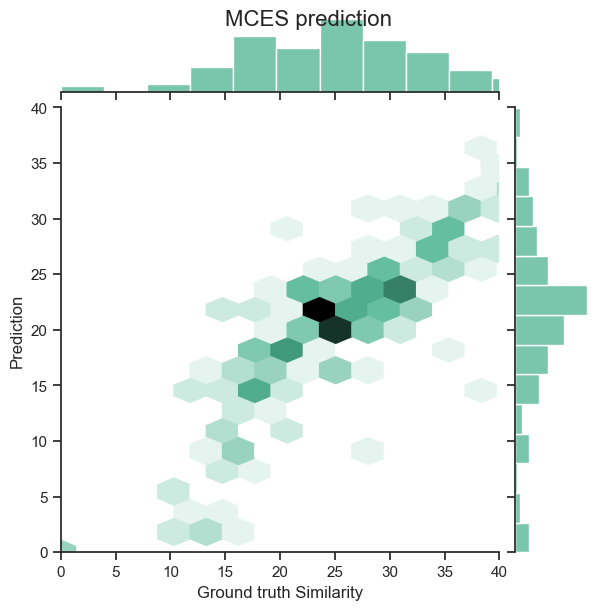

In [199]:
Plotting.plot_mces(np.reshape(ground_truth_mces,-1), np.reshape(sim_mces,-1))

Accuracy: 0.79


/Users/sebas/projects/temp_metabolomics/simba/simba/simba/plotting.py:32: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


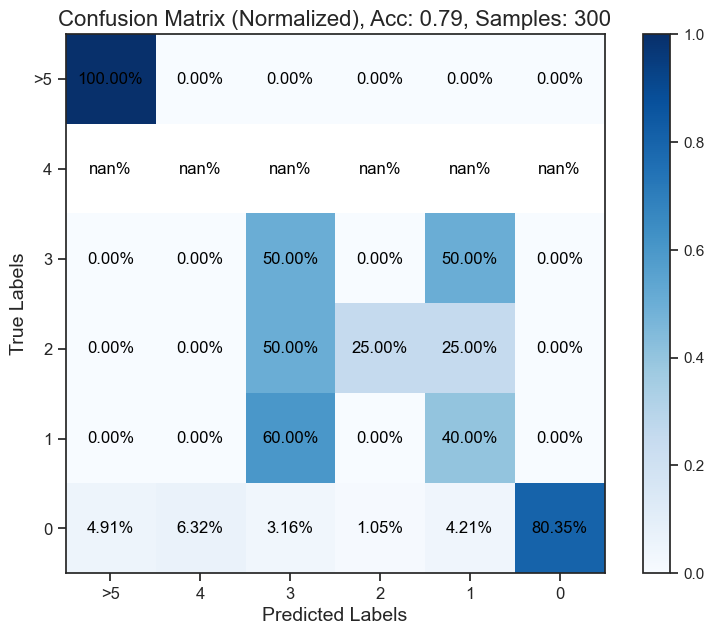

In [200]:
Plotting.plot_cm(np.reshape(ground_truth_ed,-1), np.reshape(sim_ed,-1))

## Check the closest spectra

* It returns a ranking matrix where if the score is higher, the similarity is higher based on reranking of MCES and Edit distance 

In [202]:

ranking= AnalogDiscovery.compute_ranking(sim_mces, sim_ed)

## Plot the closest spectra

In [277]:
target_index=6

In [278]:
best_match_index= np.argmax(ranking[target_index])


* Ground truth

In [279]:
print(f'Edit distance {ground_truth_ed[target_index, best_match_index]}, MCES distance {ground_truth_mces[target_index, best_match_index]}')

Edit distance 5.0, MCES distance 20.0


* Prediction

In [280]:
print(f'Edit distance {sim_ed[target_index, best_match_index]}, MCES distance {sim_mces[target_index, best_match_index]}')

Edit distance 5, MCES distance 9.163217544555664


In [281]:
spectra_0= all_spectrums_0[target_index]

In [282]:
spectra_1= all_spectrums_1[best_match_index]

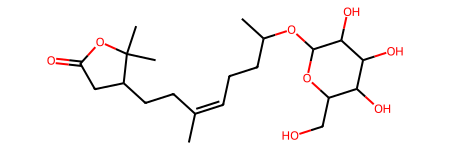

In [283]:
Chem.MolFromSmiles(spectra_0.params['smiles'])

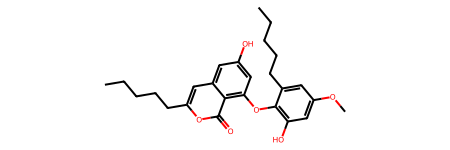

In [284]:
Chem.MolFromSmiles(spectra_1.params['smiles'])

In [285]:
spectra_0.params

{'spectrumid': '334 M+H',
 'name': '334 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 334,
 'smiles': 'CC(=CCCC(C)OC1OC(CO)C(O)C(O)C1O)CCC1CC(=O)OC1(C)C',
 'ionmode': 'Positive',
 'pepmass': [417.247928865327],
 'charge': [1],
 'libraryquality': 1}

In [286]:
spectra_1.params

{'spectrumid': '423 M+H',
 'name': '423 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 423,
 'smiles': 'CCCCCc1cc2cc(O)cc(Oc3c(O)cc(OC)cc3CCCCC)c2c(=O)o1',
 'ionmode': 'Positive',
 'pepmass': [441.226683930043],
 'charge': [1],
 'libraryquality': 1}

<Axes: xlabel='m/z', ylabel='Intensity'>

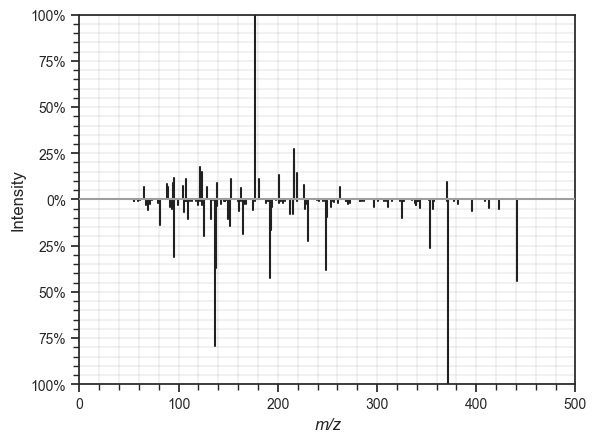

In [287]:
sup.mirror(spectra_0, spectra_1)